In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

import nltk
nltk.download("punkt")
nltk.download("stopwords")
from nltk.corpus import stopwords
from wordcloud import WordCloud

import re
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
resume_data = pd.read_csv("UpdatedResumeDataSet.csv", encoding = "UTF-8")
resume_data["cleanedResume"] = ""
resume_data.head()

,Category,Resume,cleanedResume
0,Data Science,Skills * Programming Languages: Python (pandas...,
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",


Distinct categories of resume and the number of records belonging to each category:

In [3]:
print(resume_data["Category"].unique())
print(resume_data["Category"].value_counts())

['Data Science' 'HR' 'Advocate' 'Arts' 'Web Designing'
 'Mechanical Engineer' 'Sales' 'Health and fitness' 'Civil Engineer'
 'Java Developer' 'Business Analyst' 'SAP Developer' 'Automation Testing'
 'Electrical Engineering' 'Operations Manager' 'Python Developer'
 'DevOps Engineer' 'Network Security Engineer' 'PMO' 'Database' 'Hadoop'
 'ETL Developer' 'DotNet Developer' 'Blockchain' 'Testing']
Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Operations Manager           40
Data Science                 40
Blockchain                   40
Mechanical Engineer          40
Sales                        40
ETL Developer                40
Arts                         36
Database                     33
Health and fitness           30
PMO                          30
Electrical Engineering       30
DotNet Developer           

Number of categories in the dataset:

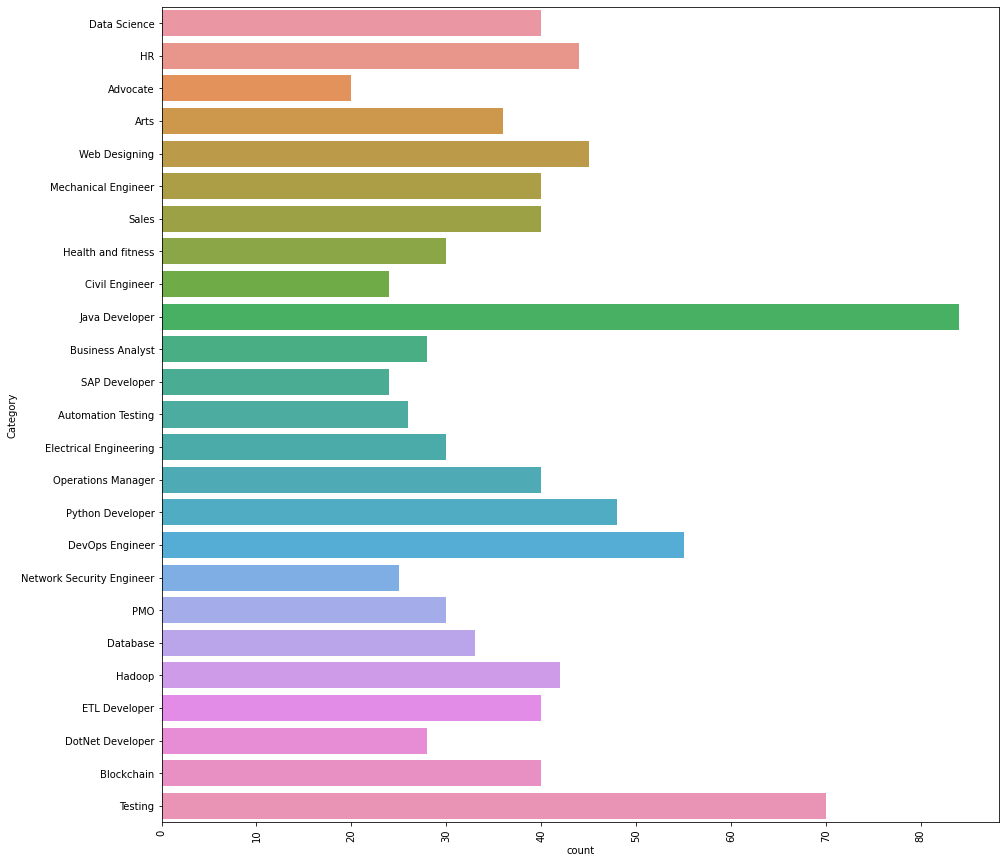

In [4]:
plt.figure(figsize = (15, 15))
plt.xticks(rotation = 90)

sns.countplot(y = "Category", data = resume_data)

Distribution of categories:

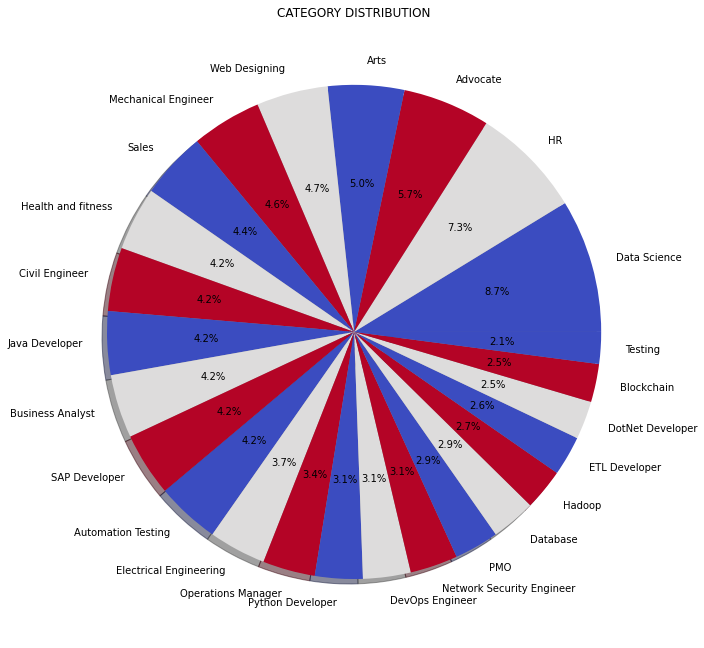

In [5]:
targetCounts = resume_data["Category"].value_counts()
targetLabels  = resume_data["Category"].unique()

# Make square figures and axes
plt.figure(1, figsize = (25,25))
the_grid = GridSpec(2, 2)

cmap = plt.get_cmap("coolwarm")
colors = [cmap(i) for i in np.linspace(0, 1, 3)]
plt.subplot(the_grid[0, 1], aspect = 1, title = "CATEGORY DISTRIBUTION")

source_pie = plt.pie(targetCounts, labels = targetLabels, autopct = "%1.1f%%", shadow = True, colors = colors)
plt.show()

Function to remove the URLs, hashtags, mentions, special letters, and punctuations:

In [6]:
def clean_resume(resumeText):
    resumeText = re.sub("http\S+\s*", " ", resumeText)  # remove URLs
    resumeText = re.sub('RT|cc', " ", resumeText)  # remove RT and cc
    resumeText = re.sub('#\S+', "", resumeText)  # remove hashtags
    resumeText = re.sub("@\S+", "  ", resumeText)  # remove mentions
    resumeText = re.sub("[%s]" % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), " ", resumeText)  # remove punctuations
    resumeText = re.sub(r"[^\x00-\x7f]",r" ", resumeText) 
    resumeText = re.sub("\s+", " ", resumeText)  # remove extra whitespace
    return resumeText

In [7]:
resume_data["cleanedResume"] = resume_data.Resume.apply(lambda x: clean_resume(x))
resume_data.head()

,Category,Resume,cleanedResume
0,Data Science,Skills * Programming Languages: Python (pandas...,Skills Programming Languages Python pandas num...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,Education Details May 2013 to May 2017 B E UIT...
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",Areas of Interest Deep Learning Control System...
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,Skills R Python SAP HANA Tableau SAP HANA SQL ...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",Education Details MCA YMCAUST Faridabad Haryan...


Wordcloud represents the most numbers of words larger and vice versa:

[('Details', 484), ('Exprience', 446), ('months', 376), ('company', 330), ('description', 310), ('1', 290), ('year', 232), ('January', 216), ('Less', 204), ('Data', 200), ('data', 192), ('Skill', 166), ('Maharashtra', 166), ('6', 164), ('Python', 156), ('Science', 154), ('I', 146), ('Education', 142), ('College', 140), ('The', 126), ('project', 126), ('like', 126), ('Project', 124), ('Learning', 116), ('India', 114), ('Machine', 112), ('University', 112), ('Web', 106), ('using', 104), ('monthsCompany', 102), ('B', 98), ('C', 98), ('SQL', 96), ('time', 92), ('learning', 90), ('Mumbai', 90), ('Pune', 90), ('Arts', 90), ('A', 84), ('application', 84), ('Engineering', 78), ('24', 76), ('various', 76), ('Software', 76), ('Responsibilities', 76), ('Nagpur', 76), ('development', 74), ('Management', 74), ('projects', 74), ('Technologies', 72)]


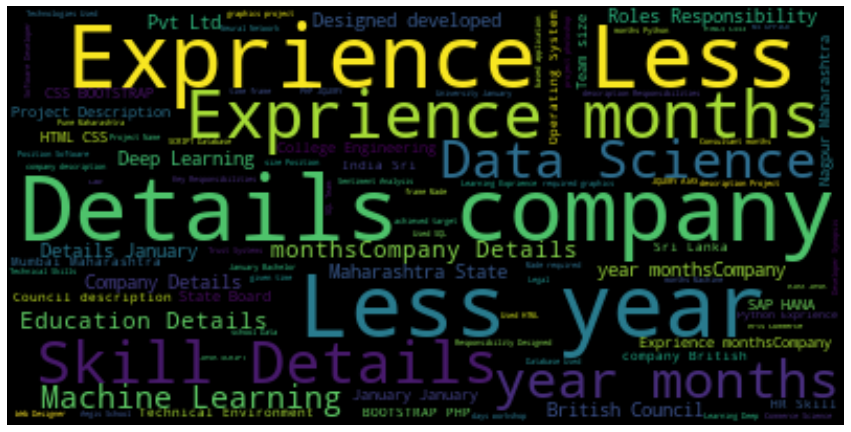

In [8]:
oneSetOfStopWords = set(stopwords.words("english")+['``',"''"])
totalWords =[]
Sentences = resume_data["Resume"].values
cleaned_sentences = ""
for i in range(0,160):
    cleaned_text = clean_resume(Sentences[i])
    cleaned_sentences += cleaned_text
    requiredWords = nltk.word_tokenize(cleaned_text)
    for word in requiredWords:
        if word not in oneSetOfStopWords and word not in string.punctuation:
            totalWords.append(word)
    
wordfreqdist = nltk.FreqDist(totalWords)
mostcommon = wordfreqdist.most_common(50)
print(mostcommon)

wc = WordCloud().generate(cleaned_sentences)
plt.figure(figsize = (15,15))
plt.imshow(wc, interpolation = "bilinear")
plt.axis("off")
plt.show()

Convert these words into categorical values:

In [9]:
var_mod = ["Category"]
le = LabelEncoder()
for i in var_mod:
    resume_data[i] = le.fit_transform(resume_data[i])

Split the data into training and test sets:

In [10]:
requiredText = resume_data["cleanedResume"].values
requiredTarget = resume_data["Category"].values

word_vectorizer = TfidfVectorizer(sublinear_tf = True, stop_words = "english", max_features = 1500)
word_vectorizer.fit(requiredText)
WordFeatures = word_vectorizer.transform(requiredText)

X_train, X_test, y_train, y_test = train_test_split(WordFeatures, requiredTarget, random_state = 42, test_size=0.25)
print(X_train.shape)
print(X_test.shape)

(721, 1500)
(241, 1500)


Train the model and print the classification report:

In [11]:
clf = OneVsRestClassifier(KNeighborsClassifier())
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)

print(f"Accuracy of KNeighbors Classifier on training set: {clf.score(X_train, y_train)}")
print(f"Accuracy of KNeighbors Classifier on test set: {clf.score(X_test, y_test)}")

print(f"\n Classification report for classifier {clf}:\n{classification_report(y_test, prediction)}\n")

Accuracy of KNeighbors Classifier on training set: 0.984743411927878
Accuracy of KNeighbors Classifier on test set: 0.970954356846473

 Classification report for classifier OneVsRestClassifier(estimator=KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=None, n_neighbors=5,
                                                   p=2, weights='uniform'),
                    n_jobs=None):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00         5
           5       0.90      1.00    